In [84]:
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [85]:
from fastbook import *
from fastai.vision.all import *
from torchvision.transforms import Grayscale, ToTensor
import pandas as pd

# Exercise 1

Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?

## Import & explore dataset sample

In [86]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#4) [Path('train'),Path('labels.csv'),Path('valid'),Path('models')]

In [87]:
three_path = (path/'train'/'3').ls().sorted()
image = Image.open(three_path[1])
array(image).shape

((28, 28), 'L')

In [88]:
for num_path in (path/'train').ls():
  print(f"{num_path} : {len((path/'train'/'3').ls().sorted())}")

/root/.fastai/data/mnist_sample/train/3 : 6131
/root/.fastai/data/mnist_sample/train/7 : 6131


## Creating dataloaders

In [89]:
class ToGrayscale(Transform):
    def encodes(self, img: PILImage):
        return img.convert('L')

In [90]:
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    seed=42,
    item_tfms=[Resize(28), ToGrayscale()],
    batch_tfms=Normalize.from_stats(0.5, 0.5),
    bs=64
)

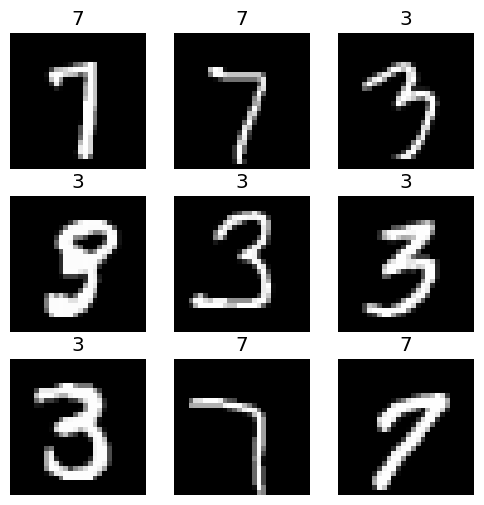

In [91]:
dls.show_batch(max_n=9, figsize=(6, 6), cmap='gray')

## Model definition

In [92]:
def get_model(nb_classes):
  return nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
      nn.Linear(64, nb_classes)
  )

## Training

SuggestedLRs(valley=0.02290867641568184)

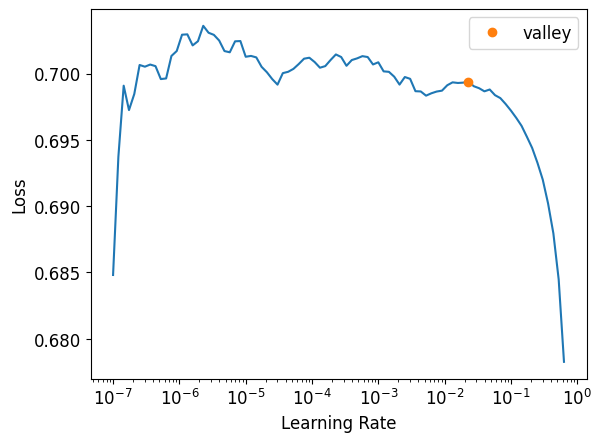

In [93]:
nb_classes = 2

learner = Learner(dls, get_model(nb_classes), opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.lr_find()

In [94]:
learner.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.681441,0.669850,0.839549,00:32
1,0.540299,0.453413,0.937193,00:33
2,0.235624,0.199919,0.947498,00:33
3,0.175345,0.175359,0.946025,00:33
4,0.172566,0.173256,0.946025,00:31


We obtain 94% precision after 5 epochs, time to evaluate on full MNIST dataset.

## Using full dataset

In [95]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

SuggestedLRs(valley=0.14454397559165955)

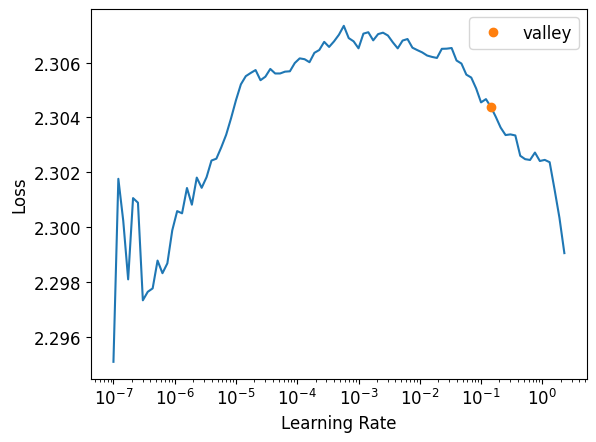

In [96]:
dls = ImageDataLoaders.from_folder(
    path,
    train='training',
    valid='testing',
    seed=42,
    item_tfms=[Resize(28), ToGrayscale()],
    batch_tfms=Normalize.from_stats(0.5, 0.5),
    bs=64
)

nb_classes = 10

learner = Learner(dls, get_model(nb_classes), opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.lr_find()

In [97]:
learner.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.590264,1.535049,0.482800,02:38
1,1.451017,1.489005,0.509300,02:31
2,1.361451,1.385753,0.557300,03:26
3,1.387785,1.367290,0.560400,02:55
4,1.345592,1.358015,0.561700,03:15


In [99]:
non_adaptive_model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.Flatten(),
      nn.Linear(64*4*4, nb_classes)
  )

learner = Learner(dls, non_adaptive_model, opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.390831,0.327860,0.905000,03:08
1,0.333704,0.299174,0.918700,03:03
2,0.285283,0.297030,0.916600,03:11
3,0.274857,0.275593,0.921500,02:53
4,0.266816,0.273856,0.921800,02:53


In both cases 5 epochs isn't enough to see signs of overfitting.

|            | with adaptive pooling | without |
|:----------|:----------:|:----------:|
| precision (5 epochs) | 56,2% | 92,2% |  
  
Adaptive average pooling isn't adapted to the MNIST use case as it reduces drastically the features used by the last dense layer to classify the written number.

# Exercise 2

In *chapter_foundations* we introduce Einstein summation notation. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using torch.einsum. Compare it to the same operation using torch.conv2d.

# Exercise 3

Write a "top-5 accuracy" function using plain PyTorch or plain Python.

# Exercise 4

Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.